In [89]:
%matplotlib inline
import rebound as r
import numpy as np
import matplotlib.pyplot as plt

## Simulated data:

In [245]:
data_N = 30
data_t = np.linspace(0.1,100,data_N)+0.5*np.random.rand(data_N)
data_rv = 0.500883379885605*(np.sin(2.*np.pi*data_t/50.+0.2*np.pi)+0.6*(np.random.rand(data_N)-0.5))

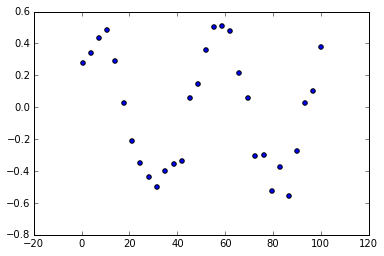

In [246]:
plt.scatter(data_t, data_rv);

## Setting up simulation
This implementation is very slow (does about 5 times more work than necessary).

In [247]:
def simulation(param):
    cart,coord = param
    r.reset()
    r.add(m=1.)
    
    op = r.Particle(a=cart[0],e=cart[1],anom=cart[2],omega=cart[3])
    
    r.add(op)
    r.init_megno(0.)
    ps = r.particles
    
    delta = 1e-6
    cart2 = cart.copy()
    cart2[coord] += delta
    mp = r.Particle(primary=ps[0],a=cart2[0],e=np.clip(cart2[1],0.,0.9),anom=cart2[2],omega=cart2[3])
    ps[3].x  = ps[1].x  - mp.x
    ps[3].y  = ps[1].y  - mp.y
    ps[3].z  = ps[1].z  - mp.z
    ps[3].vx = ps[1].vx - mp.vx
    ps[3].vy = ps[1].vy - mp.vy
    ps[3].vz = ps[1].vz - mp.vz
     
    sim_rv = np.zeros(data_N)
    sim_rvd = np.zeros(data_N)
    for i,t in enumerate(data_t):
        r.integrate(t)
        sim_rv[i]  = (ps[1].vx)
        sim_rvd[i] = (ps[1].vx+ps[3].vx)
    err  = np.sqrt(np.sum(np.square(np.subtract(sim_rv,data_rv))))
    errd = np.sqrt(np.sum(np.square(np.subtract(sim_rvd,data_rv))))
    return err, -(errd-err)/delta, sim_rv

In [248]:
def sim_array(param):
    gradient = np.zeros(4)
    for i in range(0,4):
        err, der, sim_rv =  simulation((param,i))
        gradient[i] = der
    return err, gradient, sim_rv

## Gradient descent to find minimum

In [255]:
gamma = 0.000005
a = np.array([4.5,0.6,0.,0.]) # initial parameters
sim_rvs = []             # for plotting
errs = []
lastp = 1e200
lasta = a
lastgradient = []
for i in range(600): 
    err, gradient, sim_rv = sim_array(a)

    p = err
    if p/lastp < 1.+0.5*np.random.random():
        # Accept new step
        lastp = p
        lasta = a
        sim_rvs.append(sim_rv)
        errs.append(p)
        # New step proposal
        gamma = 1e-1*np.power(10.,-6.*np.random.random())
        a = np.subtract(a,gamma*gradient)
        a[1] = np.clip(a[1],0.,0.9)
        lastgradient = gradient.copy()
    else:
        gamma = 1e-1*np.power(10.,-6.*np.random.random())
        a = np.subtract(lasta,gamma*lastgradient)
        a[1] = np.clip(a[1],0.,0.9)


        

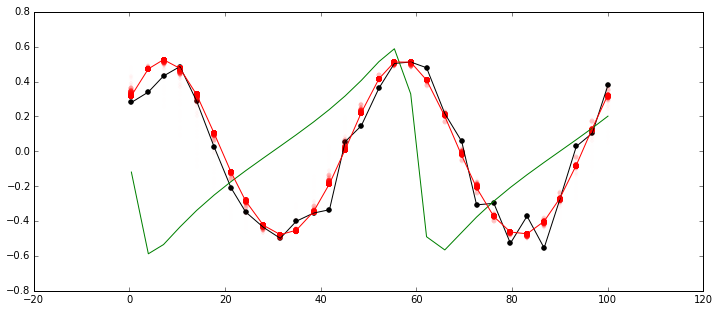

In [256]:
fig = plt.figure(figsize=(12,5))
plt.scatter(data_t, data_rv, color="k");
plt.plot(data_t, data_rv, color="k");
plt.plot(data_t, sim_rvs[0],color="g");
plt.plot(data_t, sim_rvs[-1],color="r");
opacity = 1.
for sim_rv in reversed(sim_rvs):
    plt.scatter(data_t, sim_rv,color="r", alpha=opacity);
    opacity *= 0.985

Black curve is data, green curve is initial guess. Red dots show the series converging towards the data. Red curve is final "fit".

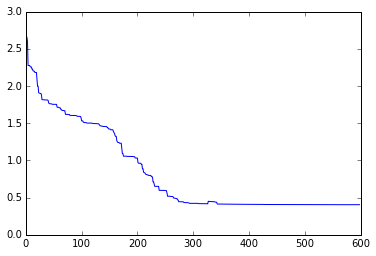

In [257]:
plt.plot(errs);